### External Validation Test for MHC Class I Prediction

This notebook performs external validation testing based on five pre-trained models for MHC Class I prediction. The goal is to evaluate the performance of the trained models on external data.

#### Requirements
1. **Amino acid interaction preference matrix between HLA allele and immunogenic peptide** : a part of feature generation
2. **Pre-trained Model Weights**: Weights from five fold based trained models.
3. **Feature Indices**: Selected feature indices obtained using RFECV.
4. **External Dataset**: Contains 200 samples also known as independent  or unseen data.
5. **Keras Functional API Models**:  Model  built using Keras Functional API.

### Purpose
To validate the robustness and accuracy of the trained models on unseen external data and analyze their predictive performance.


In [1]:
import os
import sys
os.environ["CUDa_VISIBLE-DEVICES"] = "0" ## Selection of GPU

In [2]:
import pickle
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
# TensorFlow and Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    concatenate
)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy, binary_focal_crossentropy
from keras.utils import plot_model
from keras_self_attention import SeqSelfAttention

# Scikit-learn Libraries
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import metrics

2024-12-31 18:31:31.684448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 18:31:31.701332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 18:31:31.723451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 18:31:31.723480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 18:31:31.738085: I tensorflow/core/platform/cpu_feature_gua

In [3]:
print(f' keras version {keras.__version__}'), 
print(f' tensorflow version {tf.__version__}'),
print(f' python version {sys.version.split()[0]}')

 keras version 3.4.1
 tensorflow version 2.16.2
 python version 3.11.9


In [5]:
'''Load the feature data generated from amino acid interaction matrix of HLA and immunogenic neoepitope from a 
gzipped pickle file, it is mendatory of interaction matrix to test our trained model.
To create this matrix please see another directory and manin manuscript'''

data_path = "/BiO/home/jk/Research_MHC/Feature_generation/Feature_MHC_i_our_independent"  # Update with your directory, and data named
with gzip.open(data_path, "rb") as f:
    array = pickle.load(f)

print(f"Type of first element: {type(array[0])}")
print(f"Shape of feature data: {array[0].shape}")
print(f"Shape of labels: {array[1].shape}")

positive = np.sum(array[1] == 1) # positive class
negative = np.sum(array[1] == 0) # negative
print(f"Number of positive samples: {positive}")
print(f"Number of negative samples: {negative}")

data_ind = array[0]  # Feature data
label_ind = array[1]  # Labels


Type of first element: <class 'numpy.ndarray'>
Shape of feature data: (200, 3321)
Shape of labels: (200,)
Number of positive samples: 98
Number of negative samples: 102


### The selected feature indices file from the trained RFECV must be loaded and then use to encode the external validation data

In [6]:
load_features = np.load("selected_feature_mhc_i.npy") # load the feature index of 1329 
selected_feature_indices = np.where(load_features)[0]
data_selected = data_ind[:, selected_feature_indices] # encoding
data_selected = data_selected.reshape(200, 1329,1) # reshape if necessary
print(f' Shape of external (independent) validation data {data_selected.shape}')

 Shape of external (independent) validation data (200, 1329, 1)


### Model in functional keras API

In [7]:
def model_with_attention1():
    input_shape = (1329, 1)  # one-dimensional
    input_layer = Input(shape=input_shape, name='input_layer')
    # Convolutional layers
    conv1 = Conv1D(27, kernel_size=9, activation='relu', padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D()(conv1)
    conv1 = Dropout(0.7)(pool1)
    conv2 = Conv1D(4, kernel_size=8, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D()(conv2)
    conv2 = Dropout(0.6)(pool2)
    # Attention layer
    att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                           attention_activation='sigmoid', name = "attention")(conv2)
    # Flatten the output for the dense layer
    flatten = Flatten()(att)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(flatten)
    # Model instantiation
    model = Model(inputs=input_layer, outputs=output_layer)
    learning_rate = 0.001  
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer= optimizer, loss=binary_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

In [8]:
model = model_with_attention1()

2024-12-31 18:33:05.498671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 638 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-12-31 18:33:05.499617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47203 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1329, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1329, 27)       │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1329, 27)       │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 664, 27)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 664, 27)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 664, 4)         │           868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 664, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 332, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 332, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (SeqSelfAttention)    │ (None, 332, 4)         │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,329 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,608 (10.19 KB)

 Trainable params: 2,546 (9.95 KB)

 Non-trainable params: 62 (248.00 B)

### ROC curve and Prc curve

In [11]:
def ROC(temp, OutputDir):
    validation_result = temp;
    for x in [validation_result]:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        i = 0
        for val in x:
            tpr = val['tpr']
            fpr = val['fpr']
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.4f)' % (i+1, roc_auc))

            i += 1

        print;

        plt.plot([0, 1], [0, 1], linestyle='--', lw=1,color='c' , alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        fpr_tpr_save = {"fpr": mean_fpr, 'tpr' : mean_tpr}
        np.save("our_mhc_i_external_fpr, tpr.npy", fpr_tpr_save)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate',fontweight='bold')
        plt.ylabel('True Positive Rate',fontweight='bold')
        plt.legend(loc="lower right")
        plt.title(" External validation (MHC I)", fontweight='bold')
        plt.savefig('roc_External validation_independet MHC I.pdf') #save the figure in your file path
        plt.show()
        plt.close('all')
        
        
         #************************** Precision Recall Curve*********************************
        j=0
        prs = []
        pre_aucs = []
        mean_recal= np.linspace(0, 1, 100)
        for val in x:
            pre = val['prec']
            rec = val['reca']
            prs.append(np.interp(mean_recal, rec, pre))
            prs[-1][0] = 0.0
            p_r_auc = auc(rec, pre)
            pre_aucs.append(p_r_auc)
            plt.plot(rec, pre, lw=1, alpha=0.3,label='PRC fold %d (AUC = %0.3f)' % (j+1, p_r_auc))

            j += 1

        print;

        #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

        mean_pre = np.mean(prs, axis=0)
        #mean_pre[-1] = 1.0
        mean_auc = auc(mean_recal, mean_pre)
        std_auc = np.std(pre_aucs)
        plt.plot(mean_recal, mean_pre, color='b',
                 label=r'Mean PRC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_pre = np.std(prs, axis=0)
        pre_upper = np.minimum(mean_pre + std_pre, 1)
        pre_lower = np.maximum(mean_pre - std_pre, 0)
        plt.fill_between(mean_recal, pre_lower, pre_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        

        plt.xlim([0.0, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall',fontweight='bold')
        plt.ylabel('Precision',fontweight='bold')
        plt.title('Prc MHC I (External validation)',fontweight='bold')
        plt.legend(loc="lower right")
        plt.show()
        plt.close('all')

        
def cal(X,y, model):
    pred_y =  model.predict(X)
    ROCArea = roc_auc_score(y, pred_y)
    print(ROCArea)
    fpr, tpr, thresholds = roc_curve(y, pred_y)
    lossValue = None
    
    pre, rec, threshlds = precision_recall_curve(y, pred_y)
    pre = np.fliplr([pre])[0]  #so the array is increasing (you won't get negative AUC)
    rec = np.fliplr([rec])[0]  
    AUC_prec_rec = np.trapz(rec,pre)
    AUC_prec_rec = abs(AUC_prec_rec)
    
    
    return { 'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds,'pre_recall_curve':AUC_prec_rec,'prec':pre,'reca':rec}

### load the five model's weights

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.9504801920768307
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9484793917567027
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9454781912765107
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9476790716286516
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.9463785514205683


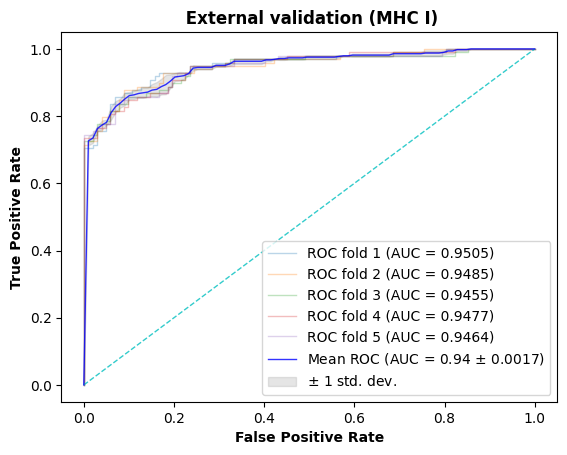

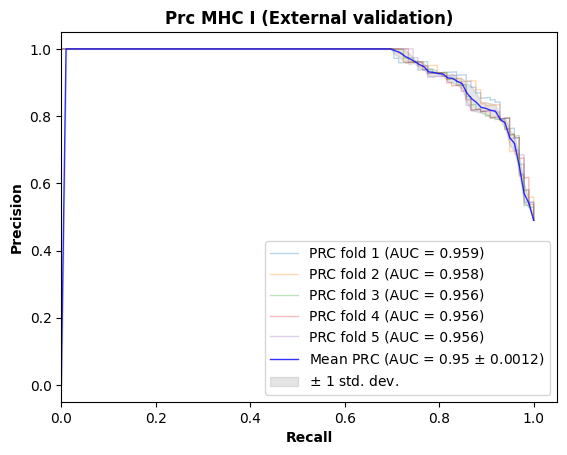

In [12]:
import warnings
warnings.filterwarnings("ignore")
OutputDir=" " # give your own path 
validation_result=[]
for i in range(5):
        model.load_weights(str(i+0)+'Lastepoch_new'+'.h5') # load model weights for five folds
        validation_result.append(cal(data_selected,label_ind, model))
        #validation_result.append(cal(data_papaya,training_label[:,1], model))
temp_dict = (validation_result)
ROC(temp_dict, OutputDir)

### Model Ability to prediction, # model can be used to predict the data directly without label

In [69]:
predictions = model.predict(data_selected)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [70]:
predictions

array([[0.98951954],
       [0.02058558],
       [0.75390416],
       [0.16321956],
       [0.01437442],
       [0.99434066],
       [0.14335427],
       [0.03379054],
       [0.08563833],
       [0.4916102 ],
       [0.06883734],
       [0.99878687],
       [0.4384611 ],
       [0.8187198 ],
       [0.36951917],
       [0.01454923],
       [0.04539985],
       [0.37796193],
       [0.02441083],
       [0.04796683],
       [0.37253967],
       [0.0939498 ],
       [0.00863529],
       [0.82481873],
       [0.7181431 ],
       [0.04892473],
       [0.9848381 ],
       [0.9958377 ],
       [0.0235998 ],
       [0.00739757],
       [0.0725364 ],
       [0.9980781 ],
       [0.9975917 ],
       [0.00766898],
       [0.9995442 ],
       [0.02331348],
       [0.7419681 ],
       [0.03585296],
       [0.999926  ],
       [0.9983734 ],
       [0.02055013],
       [0.18623218],
       [0.9988427 ],
       [0.40682912],
       [0.03025893],
       [0.02092987],
       [0.3254288 ],
       [0.011

In [62]:
predictions_binary = [ 1 if item >=0.5 else 0 for item in predictions]